In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
point_grid_path = "./out/build/grid_points.dat"
index_map_path = "./out/build/index_map.dat"
shadow_map_path = "./out/build/shadow_map.dat"

azimuth_map_path = "./out/build/azimuth_map.dat"
elevation_map_path = "./out/build/elevation_map.dat"

In [4]:
index_map = np.memmap(index_map_path, dtype=np.uint32, mode='r')
azimuth_map = np.memmap(azimuth_map_path, dtype=np.float16, mode='r')
elevation_map = np.memmap(elevation_map_path, dtype=np.float16, mode='r')
point_grid = np.loadtxt(point_grid_path)

In [5]:
# point_grid_num = 331547
# bbox_min = (84501.6, 445805, -3.747)
# resolution = 2.0
voxel_dim = (587,590,50)

In [6]:
point_grid = point_grid[:,0:6]

In [7]:
def integrate_voxel_info(point_grid, irradiance_vals, voxel_size = 2.0 ):
    voxel_grid = {}
    bbox_min = np.min(point_grid[:, :3], axis=0)
    
    def compute_intensity_for_face(normals, face_normal):
        ratio = np.sum(normals @ face_normal > 0) / len(normals)
        dot_products = normals[normals @ face_normal > 0] @ face_normal
        if len(dot_products) > 0:
            intensity = np.mean(dot_products) * ratio
        else:
            intensity = 0
        return intensity
    

    for i in range(point_grid.shape[0]):
        # point = point_grid[i]
        voxel_ids = ((point_grid[i, :3] - bbox_min) / voxel_size).astype(int)
        voxel_idx = voxel_ids[0] + voxel_ids[1] * voxel_dim[0] + voxel_ids[2] * voxel_dim[0] * voxel_dim[1]
        if voxel_idx not in voxel_grid:
            voxel_grid[voxel_idx] = {'normals': [], 'irradiance': 0}
        voxel_grid[voxel_idx]['normals'].append(point_grid[i, 3:6])
        voxel_grid[voxel_idx]['irradiance'] += irradiance_vals[i]

    
    for voxel in voxel_grid:
        normals = np.array(voxel_grid[voxel]['normals'])
        voxel_grid[voxel]['up_intensity'] = compute_intensity_for_face(normals, np.array([0, 0, 1]))+0.1
        voxel_grid[voxel]['down_intensity'] = compute_intensity_for_face(normals, np.array([0, 0, -1]))+0.1
        voxel_grid[voxel]['left_intensity'] = compute_intensity_for_face(normals, np.array([-1, 0, 0]))+0.1
        voxel_grid[voxel]['right_intensity'] = compute_intensity_for_face(normals, np.array([1, 0, 0]))+0.1
        voxel_grid[voxel]['front_intensity'] = compute_intensity_for_face(normals, np.array([0, 1, 0]))+0.1
        voxel_grid[voxel]['back_intensity'] = compute_intensity_for_face(normals, np.array([0, -1, 0]))+0.1

        intensity_sum = (voxel_grid[voxel]['up_intensity'] + voxel_grid[voxel]['down_intensity'] +
                         voxel_grid[voxel]['left_intensity'] + voxel_grid[voxel]['right_intensity'] +
                         voxel_grid[voxel]['front_intensity'] + voxel_grid[voxel]['back_intensity'])

        if intensity_sum > 0:
            for key in ['up_intensity', 'down_intensity', 'left_intensity', 'right_intensity', 'front_intensity', 'back_intensity']:
                voxel_grid[voxel][key] /= intensity_sum

    return voxel_grid


def update_grid_point_irradiance(point_grid, voxel_grid, irradiance, index_map, azimuth_map, elevation_map, voxel_size=2.0):
    num_points = point_grid.shape[0]
    num_samples = 360 * 90
    bbox_min = np.min(point_grid[:, :3], axis=0)

    updated_irradiance = irradiance.copy()

    for i in tqdm(range(num_points), desc="Processing points"):
        voxel_ids = ((point_grid[i, :3] - bbox_min) / voxel_size).astype(int)
        voxel_idx = voxel_ids[0] + voxel_ids[1] * voxel_dim[0] + voxel_ids[2] * voxel_dim[0] * voxel_dim[1]
        voxel_data = voxel_grid[voxel_idx]


        valid_mask = index_map[i*num_samples:(i+1)*num_samples] != np.iinfo(np.uint32).max
        azimuth_point = azimuth_map[i*num_samples:(i+1)*num_samples][valid_mask]
        elevation_point = elevation_map[i*num_samples:(i+1)*num_samples][valid_mask]
        
        azimuth_valid = np.radians(azimuth_point)
        elevation_valid = np.radians(elevation_point)

        directions_x = np.cos(elevation_valid) * np.cos(azimuth_valid)
        directions_y = np.cos(elevation_valid) * np.sin(azimuth_valid)
        directions_z = np.sin(elevation_valid)

        contributions = np.zeros(valid_mask.sum())
        contributions += np.where(directions_x > 0, voxel_data['right_intensity'],  voxel_data['left_intensity'])
        contributions += np.where(directions_y > 0, voxel_data['front_intensity'], voxel_data['back_intensity'])
        contributions += np.where(directions_z > 0, voxel_data['up_intensity'], voxel_data['down_intensity'])
        
        updated_irradiance[i] += np.sum(contributions * voxel_data['irradiance']/num_samples * 0.1)


    return updated_irradiance

def update_voxel(voxel_grid, point_grid, irradiance_vals, voxel_size=2.0):
    bbox_min = np.min(point_grid[:, :3], axis=0)
    
    for voxel in voxel_grid:
        voxel_grid[voxel]['irradiance'] = 0
    
    for i in range(point_grid.shape[0]):
        voxel_ids = ((point_grid[i, :3] - bbox_min) / voxel_size).astype(int)
        voxel_idx = voxel_ids[0] + voxel_ids[1] * voxel_dim[0] + voxel_ids[2] * voxel_dim[0] * voxel_dim[1]
        voxel_grid[voxel_idx]['irradiance'] += irradiance_vals[i]
    
    return voxel_grid


In [8]:
def pd_integrate_voxel_info(point_grid, irradiance_vals, voxel_size=2.0):
    voxel_grid = {}
    bbox_min = np.min(point_grid[:, :3], axis=0)
    
    def compute_intensity_for_face(normals, face_normal):
        ratio = np.sum(normals @ face_normal > 0) / len(normals)
        dot_products = normals[normals @ face_normal > 0] @ face_normal
        if len(dot_products) > 0:
            intensity = np.mean(dot_products) * ratio
        else:
            intensity = 0
        return intensity


    for i in range(point_grid.shape[0]):
        voxel_ids = ((point_grid[i, :3] - bbox_min) / voxel_size).astype(int)
        voxel_idx = voxel_ids[0] + voxel_ids[1] * voxel_dim[0] + voxel_ids[2] * voxel_dim[0] * voxel_dim[1]
        if voxel_idx not in voxel_grid:
            voxel_grid[voxel_idx] = {'normals': [], 'irradiance': 0}
        voxel_grid[voxel_idx]['normals'].append(point_grid[i, 3:6])
        voxel_grid[voxel_idx]['irradiance'] += irradiance_vals[i]

    data = []
    data.append({
        'voxel_idx': np.iinfo(np.uint32).max,
        'irradiance': 0,
        'up_intensity': 0,
        'down_intensity': 0,
        'left_intensity': 0,
        'right_intensity': 0,
        'front_intensity': 0,
        'back_intensity': 0
    })
    
    for voxel_idx, voxel_data in voxel_grid.items():
        normals = np.array(voxel_data['normals'])
        up_intensity = compute_intensity_for_face(normals, np.array([0, 0, 1])) + 0.1
        down_intensity = compute_intensity_for_face(normals, np.array([0, 0, -1])) + 0.1
        left_intensity = compute_intensity_for_face(normals, np.array([-1, 0, 0])) + 0.1
        right_intensity = compute_intensity_for_face(normals, np.array([1, 0, 0])) + 0.1
        front_intensity = compute_intensity_for_face(normals, np.array([0, 1, 0])) + 0.1
        back_intensity = compute_intensity_for_face(normals, np.array([0, -1, 0])) + 0.1

        intensity_sum = (up_intensity + down_intensity + left_intensity + right_intensity +
                         front_intensity + back_intensity)

        if intensity_sum > 0:
            up_intensity /= intensity_sum
            down_intensity /= intensity_sum
            left_intensity /= intensity_sum
            right_intensity /= intensity_sum
            front_intensity /= intensity_sum
            back_intensity /= intensity_sum

        data.append({
            'voxel_idx': voxel_idx,
            'irradiance': voxel_data['irradiance'],
            'up_intensity': up_intensity,
            'down_intensity': down_intensity,
            'left_intensity': left_intensity,
            'right_intensity': right_intensity,
            'front_intensity': front_intensity,
            'back_intensity': back_intensity
        })

    df = pd.DataFrame(data)
    df.set_index('voxel_idx', inplace=True)
    return df

In [42]:
def batch_update_grid_point_irradiance(point_grid, voxel_grid, irradiance, index_map, azimuth_map, elevation_map, voxel_size=2.0):
    num_points = point_grid.shape[0]
    num_samples = 360 * 90

    updated_irradiance = irradiance.copy()
    batch_size = 1000
    for i in tqdm(range(0, num_points, batch_size), desc="Processing points"):
        batch_start = i
        batch_end = min(i + batch_size, num_points)

        azimuth_point = azimuth_map[batch_start*num_samples:batch_end*num_samples]
        elevation_point = elevation_map[batch_start*num_samples:batch_end*num_samples]
        azimuth_valid = np.radians(azimuth_point)
        elevation_valid = np.radians(elevation_point)
        directions_x = np.cos(elevation_valid) * np.cos(azimuth_valid)
        directions_y = np.cos(elevation_valid) * np.sin(azimuth_valid)
        directions_z = np.sin(elevation_valid)
        

        voxel_indexes = index_map[batch_start*num_samples:batch_end*num_samples]
        relevant_voxels = voxel_grid.reindex(voxel_indexes, fill_value=0)

        pixels_irradiance = relevant_voxels['irradiance'].values

        up_intensities = relevant_voxels['up_intensity'].values
        down_intensities = relevant_voxels['down_intensity'].values
        left_intensities = relevant_voxels['left_intensity'].values
        right_intensities = relevant_voxels['right_intensity'].values
        front_intensities = relevant_voxels['front_intensity'].values
        back_intensities = relevant_voxels['back_intensity'].values
        
        x_mask = np.where(directions_x > 0, right_intensities, left_intensities)
        y_mask = np.where(directions_y > 0, front_intensities, back_intensities)
        z_mask = np.where(directions_z > 0, up_intensities, down_intensities)
        
        contributions = x_mask + y_mask + z_mask
        updated_irradiance[batch_start:batch_end] += np.sum(contributions * pixels_irradiance/num_samples * 0.1)
        

    return updated_irradiance

In [14]:
irradiance = np.random.uniform(0, 1000, point_grid.shape[0])
first_voxel_grid = pd_integrate_voxel_info(point_grid, irradiance)

In [43]:

batch_updated_irradiance = batch_update_grid_point_irradiance(point_grid, first_voxel_grid, irradiance, index_map, azimuth_map, elevation_map)

Processing points:  14%|█▍        | 46/332 [02:54<18:03,  3.79s/it]


KeyboardInterrupt: 

In [25]:
irradiance = np.random.uniform(0, 1000, point_grid.shape[0])
updated_voxel= integrate_voxel_info(point_grid, irradiance)


In [14]:
updated_irradiance = update_grid_point_irradiance(point_grid, updated_voxel, irradiance, index_map, azimuth_map, elevation_map)

Processing points:   7%|▋         | 22317/331547 [00:25<05:55, 868.73it/s] 


KeyboardInterrupt: 

In [ ]:
from line_profiler import LineProfiler

lp = LineProfiler()
lp_wrapper = lp(update_grid_point_irradiance)
lp_wrapper(point_grid, updated_voxel, irradiance, index_map, azimuth_map, elevation_map)
lp.print_stats()


In [ ]:
voxel_after1 = update_voxel(updated_voxel, point_grid, updated_irradiance)
irradiance2 = update_grid_point_irradiance(point_grid, voxel_after1, updated_irradiance, index_map, azimuth_map, elevation_map)
diff_01 = updated_irradiance - irradiance
non_zero_diff_01 = diff_01[diff_01 != 0]

diff_12 = irradiance2 - updated_irradiance
non_zero_diff_12 = diff_12[diff_12 != 0]

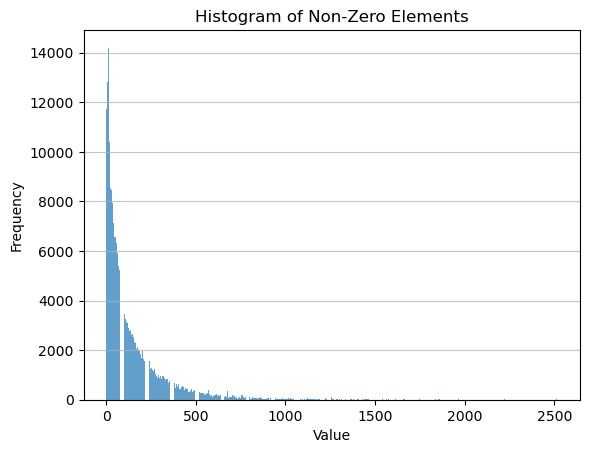

In [41]:
plt.hist(non_zero_diff_01, bins='auto', alpha=0.7, rwidth=0.85)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Non-Zero Elements')
plt.grid(axis='y', alpha=0.75)

plt.show()

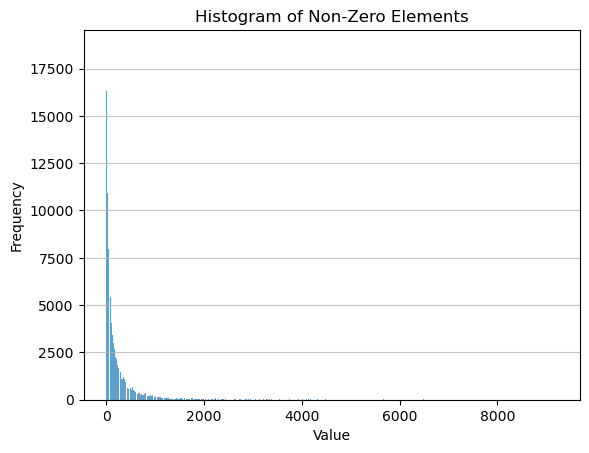

In [42]:
plt.hist(non_zero_diff_12, bins='auto', alpha=0.7, rwidth=0.85)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Non-Zero Elements')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [39]:
import numpy as np
import pandas as pd
import random
import timeit

# 生成13万对键值对
keys = np.arange(1, 130001)
values = [f'value_{i}' for i in keys]

# 将键值对数据转换为字典
map_dict = dict(zip(keys, values))

# 创建 pandas DataFrame
df = pd.DataFrame({'key': keys, 'value': values})
df.set_index('key', inplace=True)

# 创建查询keys
query_keys_32400 = np.random.choice(keys, 32400, replace=True)
query_keys_324000 = np.random.choice(keys, 324000, replace=True)

# 定义 for 循环查找
def for_loop_lookup(query_keys):
    result = []
    for key in query_keys:
        result.append(map_dict.get(key))
    return result

# 定义 pandas 查找
def pandas_lookup(query_keys):
    return df.loc[query_keys]['value'].values





for_loop_32400: 0.100410 seconds
for_loop_324000: 1.272392 seconds
pandas_32400: 0.019804 seconds
pandas_324000: 0.133374 seconds
numpy_vectorize_32400: 0.129338 seconds
numpy_vectorize_324000: 1.156629 seconds
